# Annotating cell types
This tutorial is to familiarize users with SCimilarity's basic cell annotation functionality.

System requirements:

  - At least 64GB of RAM

## 0. Required software and data
Things you need for this demo:

 0. [SCimilarity](https://github.com/Genentech/scimilarity) package should already be installed.

 1. SCimilarity trained model. [Download SCimilarity models](https://zenodo.org/record/8240464). Note, this is a large tarball - downloading and uncompressing can take a several minutes.

 2. A dataset to annotate. We will use [Adams et al., 2020](https://www.science.org/doi/10.1126/sciadv.aba1983?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed) healthy and IPF lung scRNA-seq data. [Download tutorial data](https://zenodo.org/record/8242083).

If the model hasn't been downloaded please uncomment and run the two command below

In [1]:
# !curl -L -o /models/model_v1.1.tar.gz \
#   https://zenodo.org/records/10685499/files/model_v1.1.tar.gz?download=1
# !tar -xzvf /models/model_v1.1.tar.gz

If the data hasn't been downloaded please uncomment and run the two command below

In [2]:
# !curl -L -o "/data/GSE136831_subsample.h5ad" \
#   https://zenodo.org/record/8242083/files/GSE136831_subsample.h5ad?download=1

In [3]:
import scanpy as sc
from matplotlib import pyplot as plt

sc.set_figure_params(dpi=100)
plt.rcParams["figure.figsize"] = [6, 4]

import warnings

warnings.filterwarnings("ignore")

## 1. Prepare for SCimilarity: Import and normalize data

In [4]:
from scimilarity.utils import lognorm_counts, align_dataset
from scimilarity import CellAnnotation

### Import SCimilarity - Cell annotation object

In [5]:
# Instantiate the CellAnnotation object
# Set model_path to the location of the uncompressed model
model_path = "/models/model_v1.1"
ca = CellAnnotation(model_path=model_path)

### Load scRNA-seq data

In [6]:
# Load the tutorial data
# Set data_path to the location of the tutorial dataset
data_path = "/data/GSE136831_subsample.h5ad"
adams = sc.read(data_path)

### SCimilarity pre-processing
SCimilarity requires new data to be processed in a specific way that matches how the model was trained. 

#### Match feature space with SCimilarity models 
SCimilarity's gene expression ordering is fixed. New data should be reorderd to match that, so that it is consistent with how the model was trained. Genes that are not present in the new data will be zero filled to comply to the expected structure. Genes that are not present in SCimilarity's gene ordering will be filtered out. 

Note, SCimilarity was trained with high data dropout to increase robustness to differences in gene lists. 

In [7]:
adams = align_dataset(adams, ca.gene_order)

#### Normalize data consistent with SCimilarity
It is important to match Scimilarity's normalization so that the data matches the lognorm tp10k procedure used during model training.

In [8]:
adams = lognorm_counts(adams)

With these simple steps, the data is now ready for SCimilarity. We are able to filter cells whenever we want (even after embedding) because SCimilarity handles each cell independently and can skip highly variable gene selection altogether.

## 2. Compute embeddings
Using the already trained models, SCimilarity can embed your new dataset. 

In [9]:
adams.obsm["X_scimilarity"] = ca.get_embeddings(adams.X)

### Compute visualization of embeddings
#### Use UMAP to visualize SCimilarity embeddings

In [10]:
sc.pp.neighbors(adams, use_rep="X_scimilarity")
sc.tl.umap(adams)

### Visualize author annotations on the SCimilarity embedding

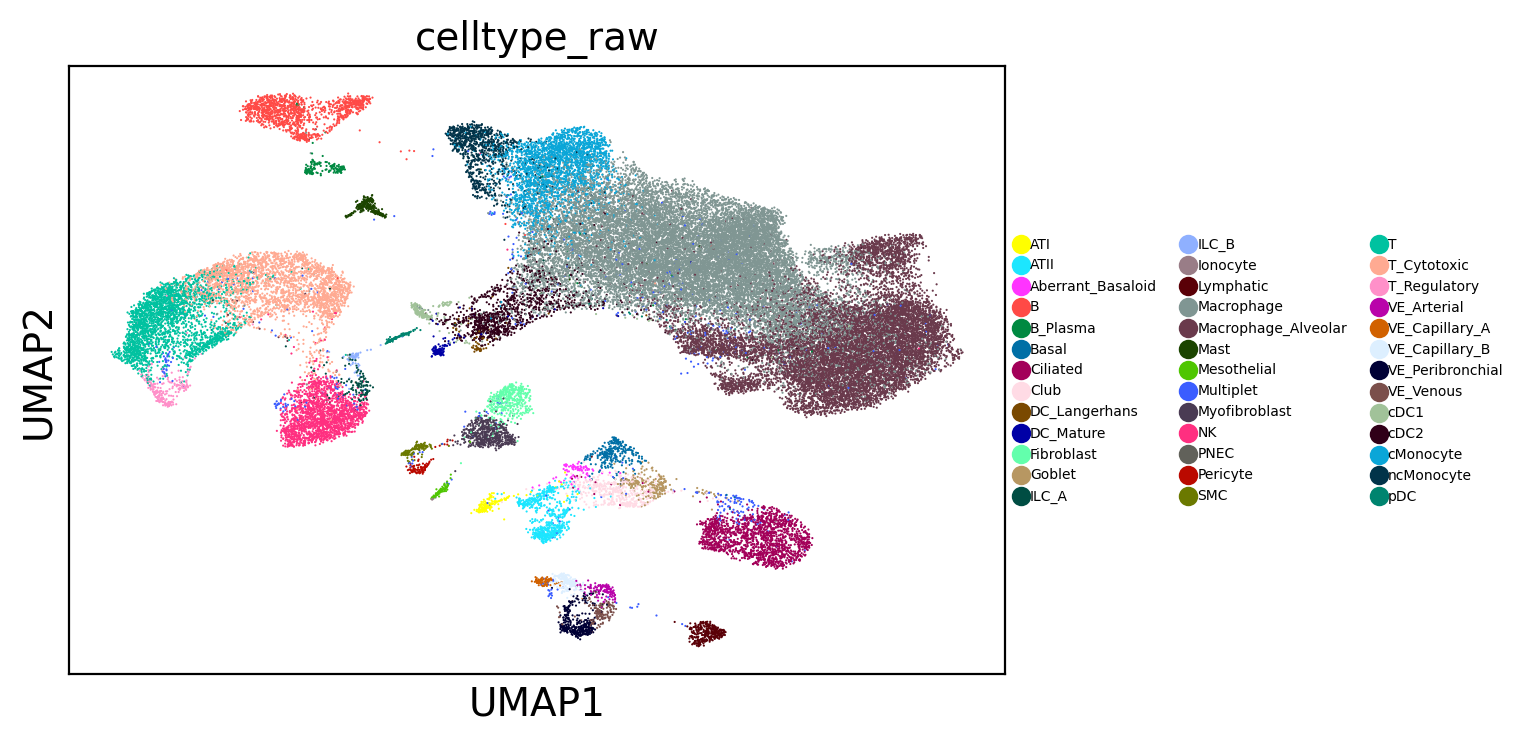

In [11]:
sc.pl.umap(adams, color="celltype_raw", legend_fontsize=5)

Given that author annotations are derived from a different analysis, seeing author annotations roughly cluster in SCimilarity embedding space gives us confidence in our representation. The Adams et al. dataset was not included in the training set, meaning that this is the first time the model has seen this data, yet it is still able to represent the cells present.

## 3. Cell type classification

Two methods within the CellAnnotation class:
 1. `annotate_dataset` - automatically computes embeddings.
 2. `get_predictions` - more detailed control of annotation.

*Description of inputs*
 - `X_scimilarity`: embeddings from the model, which can be used to generate UMAPs in lieu of PCA and is generalized across datasets.   

*Description of outputs*
 - `predictions`: cell type annotation predictions.
 - `nn_idxs`: indicies of cells in the SCimilarity reference. 
 - `nn_dists`: the minimum distance within k=50 nearest neighbors.
 - `nn_stats`: a dataframe containing useful metrics such as: 
   - `hits`: the distribution of celltypes in k=50 nearest neighbors.

### Unconstrained annotation
Cells can be classified as any type that is in the SCimilarity reference 

In [12]:
predictions, nn_idxs, nn_dists, nn_stats = ca.get_predictions_kNN(
    adams.obsm["X_scimilarity"]
)
adams.obs["predictions_unconstrained"] = predictions.values

Get nearest neighbors finished in: 0.025613037745157878 min


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:31<00:00, 1609.37it/s]


Since each cell is classified independently, there is higher classification noise, filtering out low count cells can reduce the noise in visualization.

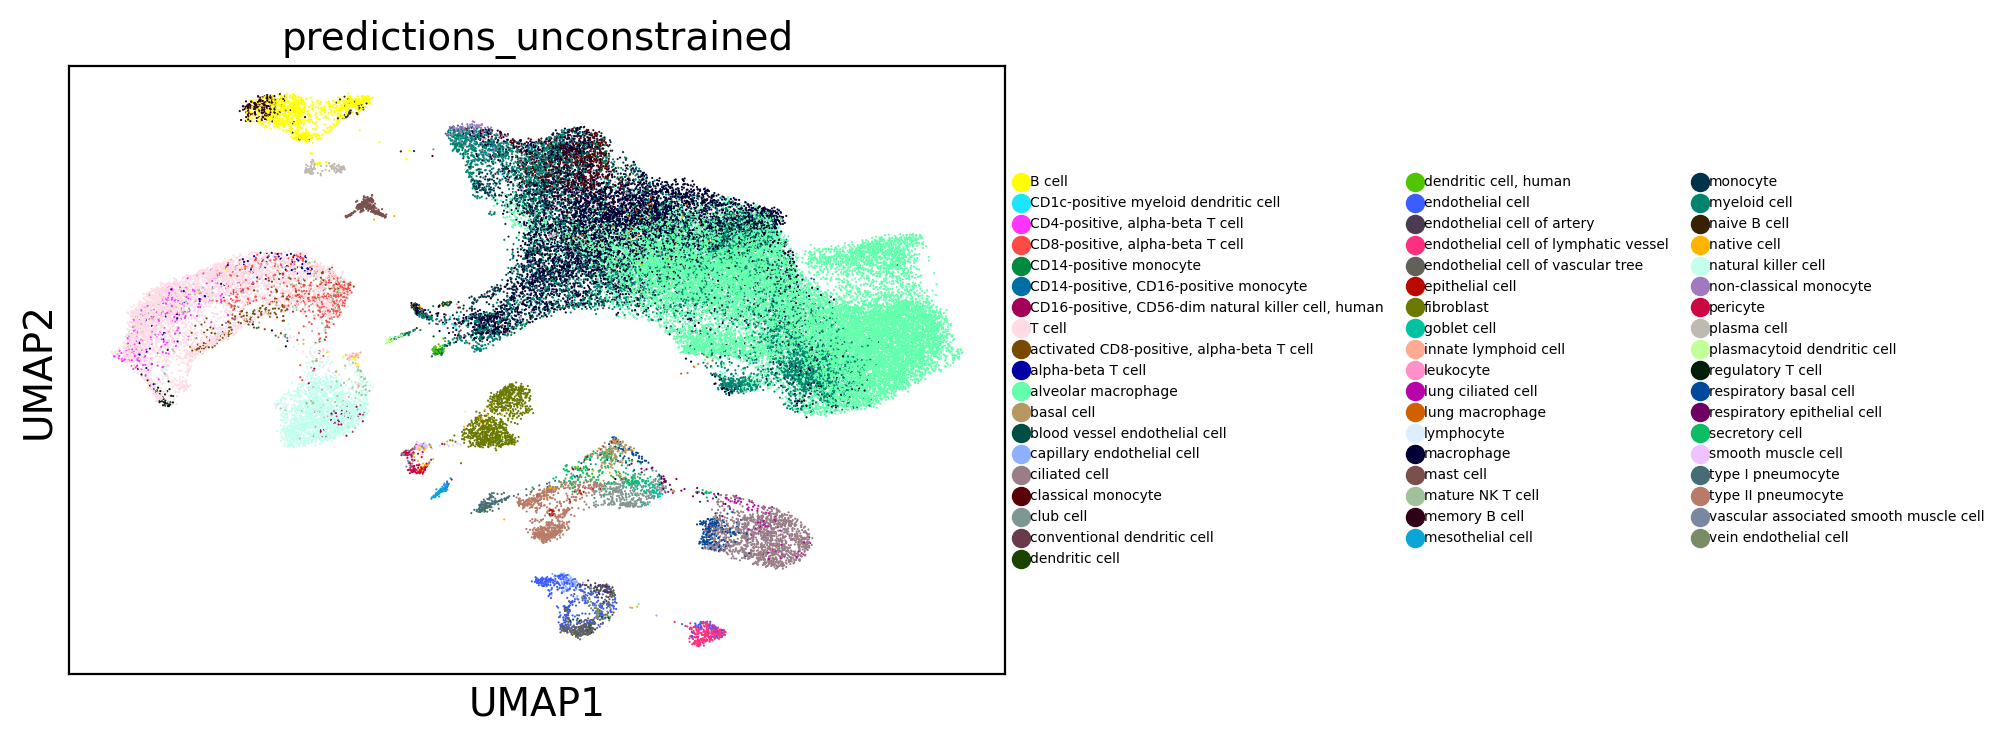

In [13]:
celltype_counts = adams.obs.predictions_unconstrained.value_counts()
well_represented_celltypes = celltype_counts[celltype_counts > 20].index

sc.pl.umap(
    adams[adams.obs.predictions_unconstrained.isin(well_represented_celltypes)],
    color="predictions_unconstrained",
    legend_fontsize=5,
)

### Constrained classification
By classifying against the full reference, we can get redundant cell types, such as activated CD8-positive, alpha-beta T cell and CD8-positive, alpha-beta T cell.

Alternatively, we can subset the reference to just the cell types we want to classify to. This also reduces noise in cell type annotation.

Note, subsetting can slow classification speeds as the kNN is optimized for the full reference.

In [14]:
target_celltypes = [
    "alveolar macrophage",
    "macrophage",
    "natural killer cell",
    "ciliated cell",
    "mature NK T cell",
    "B cell",
    "fibroblast",
    "classical monocyte",
    "type II pneumocyte",
    "endothelial cell of vascular tree",
    "club cell",
    "endothelial cell of lymphatic vessel",
    "CD8-positive, alpha-beta T cell",
    "respiratory basal cell",
    "mast cell",
    "type I pneumocyte",
    "secretory cell",
    "CD4-positive, alpha-beta T cell",
    "lung macrophage",
    "plasma cell",
    "basal cell",
    "non-classical monocyte",
    "plasmacytoid dendritic cell",
    "lung ciliated cell",
    "vascular associated smooth muscle cell",
    "conventional dendritic cell",
    "goblet cell",
    "smooth muscle cell",
    "pericyte",
    "regulatory T cell",
    "myofibroblast cell",
    "neuroendocrine cell",
    "pulmonary ionocyte",
]

ca.safelist_celltypes(target_celltypes)

In [15]:
adams = ca.annotate_dataset(adams)

Get nearest neighbors finished in: 0.04770147403081258 min


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:31<00:00, 1580.26it/s]


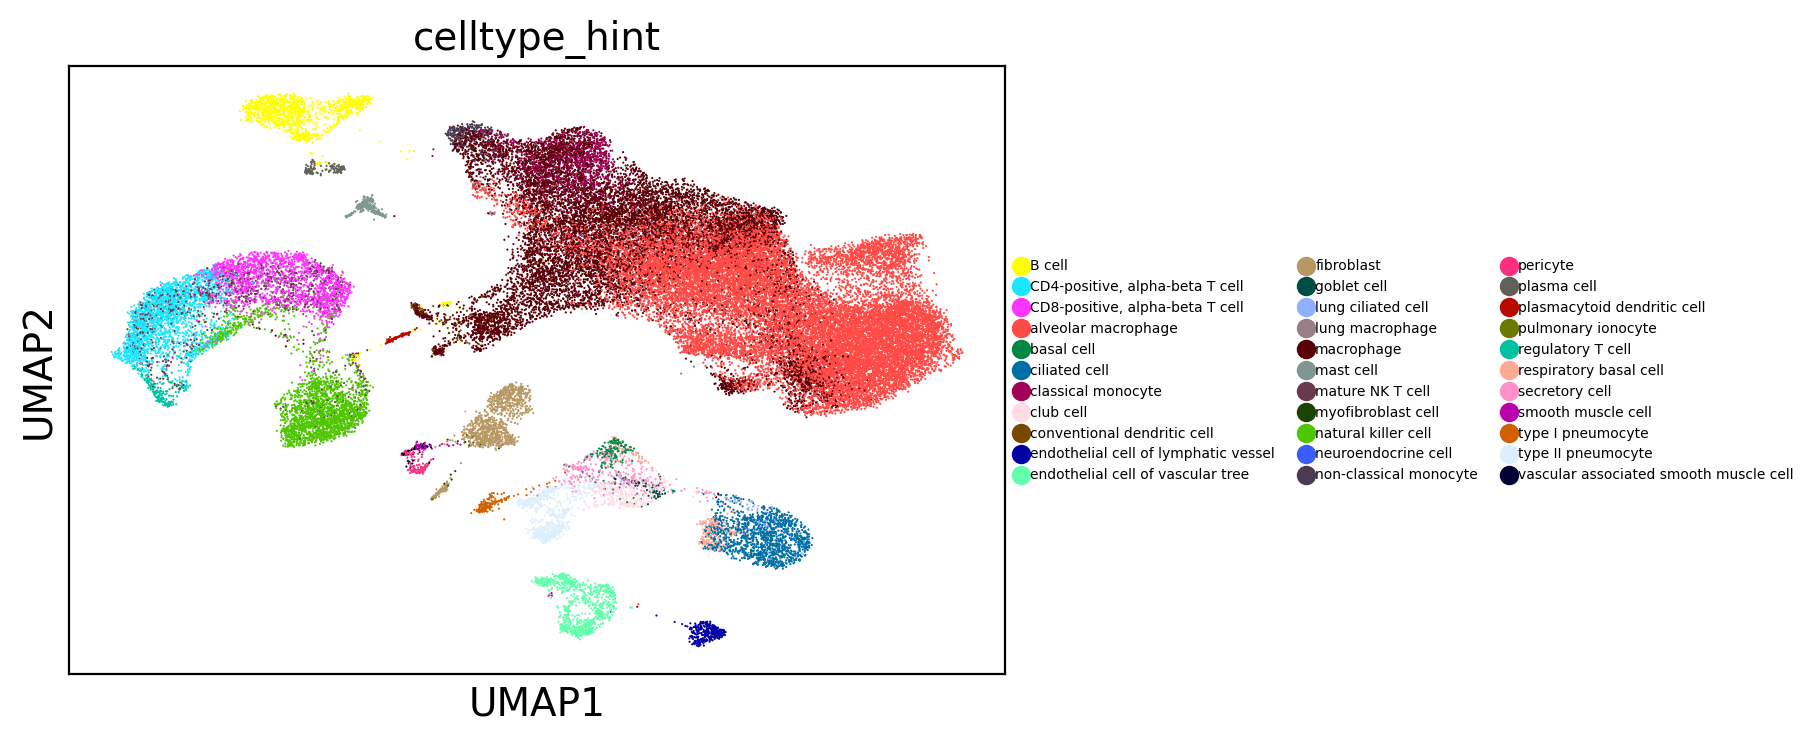

In [16]:
sc.pl.umap(adams, color="celltype_hint", legend_fontsize=5)

### Annotation QC
Cell annotation also computes QC metrics for our annotations. One of which, `min_dist`, represents the minimum distance between a cell in the query dataset and all cells in the training set. The greater `min_dist`, (i.e., the further away from what the model has seen before) the less confidence we have in the model's prediction. 

Note, for different applications and questions different `min_dist` ranges have different implications.

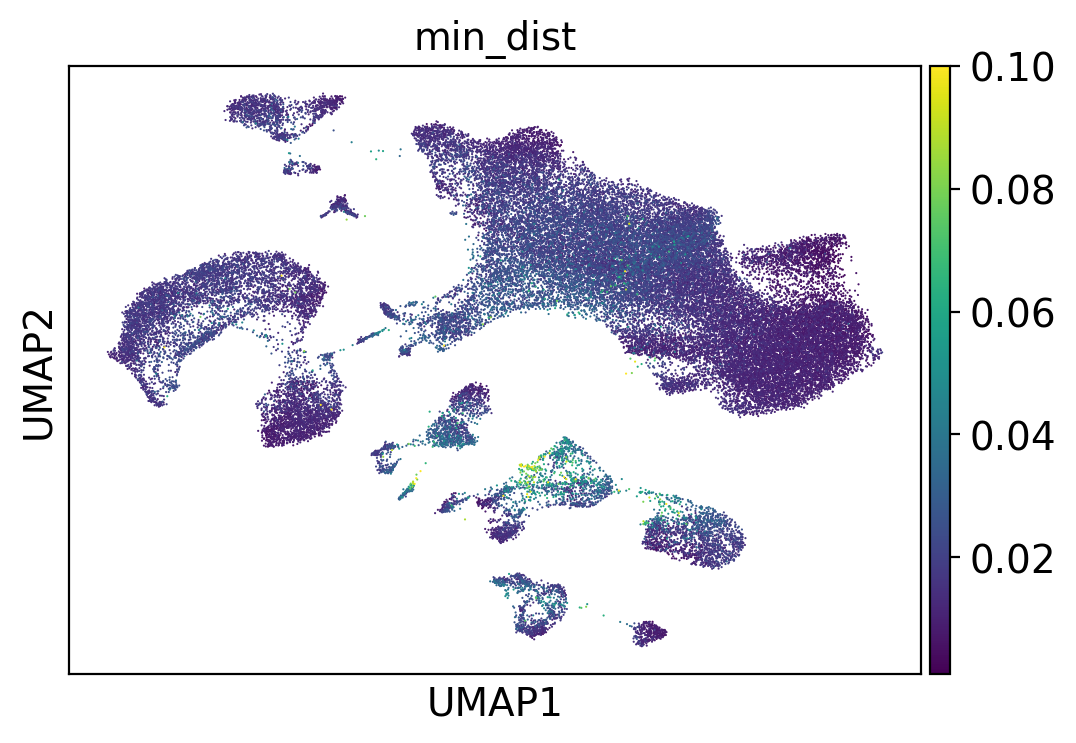

In [17]:
sc.pl.umap(adams, color="min_dist", vmax=0.1)

## Conclusion
This notebook outlines how to take a dataset and perform cell type annotation.

Keep in mind that the datasets that you analyze with SCimilarity should fit the following criteria:
  - Data generated from the 10x Genomics Chromium platform (models are trained using this data only).
  - Human scRNA-seq data.
  - Counts normalized with SCimilarity functions or using the same process. Different normalizations will have poor results.